In [1]:
import pandas as pd
import numpy as np
import rapid_review as rr
import os
import matplotlib.pyplot as plt
import importlib
from sklearn.svm import SVC, OneClassSVM
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import ast

In [25]:
datasets = ["Hall","Kitchenham","Radjenovic","Wahono"]

dfs = []
cols = ["Document Title", "Abstract", "label"]
for d in datasets:
    df = pd.read_csv(f'../data/fastread/{d}.csv', encoding="ISO-8859-1")[cols]
    df.loc[df['label']=="no", "relevant"] = 0
    df.loc[df['label']=="yes", "relevant"] = 1
    df["review"] = d
    dfs.append(df)
    
df = pd.concat(dfs)
df.head()

,Document Title,Abstract,label,relevant,review
0,Sinogram-based motion correction of PET images...,A head motion during brain imaging has been re...,no,0.0,Hall
1,A fault tolerant control architecture for auto...,A hierarchical controller for dealing with fau...,no,0.0,Hall
2,Fault tolerant memory design for HW/SW co-reli...,A highly dependable embedded fault-tolerant me...,no,0.0,Hall
3,Efficient color correction approach for phase ...,A highly efficient color correction approach b...,no,0.0,Hall
4,High-performance line conditioner with output ...,A high-performance line conditioner with excel...,no,0.0,Hall


In [ ]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

cm = plt.cm.RdYlBu


ticklabels = []
for i, (name, group) in enumerate(df.groupby('review')):
    if i==0:
        l1="included"
        l2="excluded"
    else:
        l1 = None
        l2 = None
        
    group = group.dropna()
    included = group[group['relevant']==1].shape[0]
    excluded = group[group['relevant']==0].shape[0]
    ax.barh(i-0.2, included, height=0.3, color='C1',label=l1)
    ax.barh(i+0.2, excluded, height=0.3, color='C2', label=l2)
    ax.text(included+50, i-0.2, f'{included/excluded:.1%}', ha="left", va="center")
    ticklabels.append(name)
        
ax.set_yticks([i for i,v in enumerate(ticklabels)])
ax.set_yticklabels(ticklabels)

ax.legend()
    
    
plt.show()

In [ ]:
importlib.reload(rr)

results = []
iterations = 1

df['x'] = df['Abstract']

recalculate = True
if recalculate:
    for name, group in df.groupby('review'):
        group = group.dropna().reset_index(drop=True)

        #if name != "Kitchenham":
        #    continue
        models = [
            SVC(kernel='linear',class_weight='balanced',probability=True)
            #MultinomialNB(alpha=0.1)    
            #MLPClassifier(
            #    solver='lbfgs', 
            #    alpha=0.1,
            #    hidden_layer_sizes=(10), 
            #    random_state=1
            #)
        ]

        ss = rr.ScreenScenario(
            group, models, 300, [50,100,200], name
        )
        for i in range(iterations):
            results.append(ss.screen(i, True))

    results_df = pd.DataFrame.from_dict(results)
else:
    results_df = pd.read_csv('../results/results_pb_copd.csv') 
    for p in ["estimated_recall_path", "recall_track", "work_track","random_work_track","random_recall_track"]:
        results_df[p] = results_df[p].apply(ast.literal_eval)
    
results_df.head()

Dataset: Hall, iteration 0.  6700 out of 8911 documents seen (75%) - recall: 100.00%


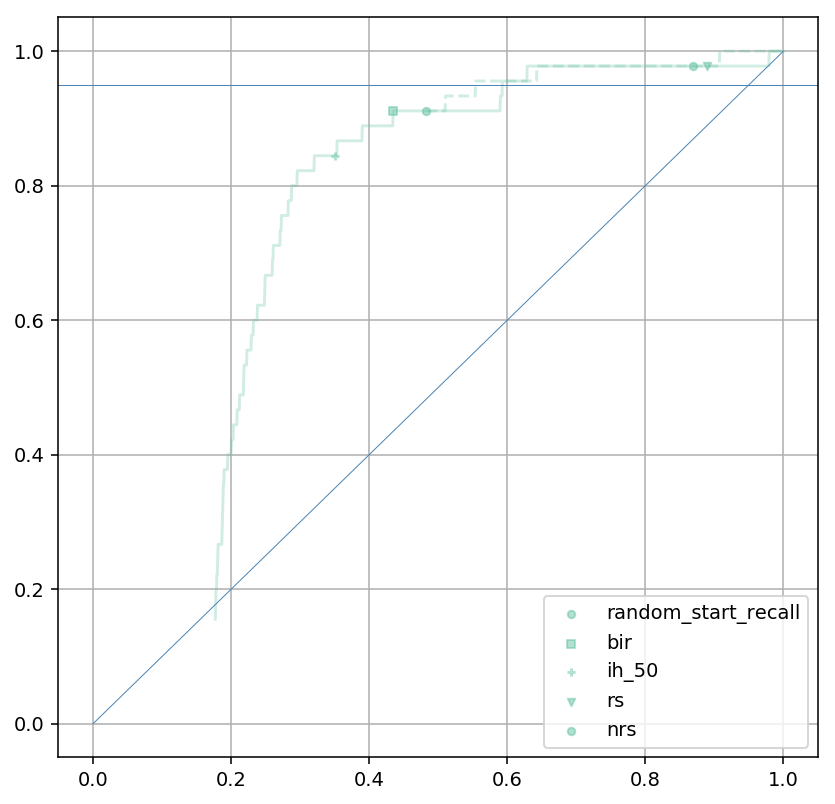

In [28]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']

a = 0.3
size = 15

pdf = results_df[results_df['N'] > 1000]

for i, p in pdf.iterrows():

    ax.plot(p['work_track'], p['recall_track'], c = colors[0], alpha=a)
    ax.plot(p['random_work_track'], p['random_recall_track'], c = colors[0], alpha=a, linestyle="--")
    #ax.plot(p['random_work_track'], p['estimated_recall_path'])
    
s_crit = ["bir","ih_50","rs","nrs"]

import itertools
marker = itertools.cycle((',', '+', 'v', 'o', '*')) 

ax.scatter(pdf['random_start_work'],pdf['random_start_recall'],c=colors[0],s=size,alpha=a+0.2)

for s in s_crit:
    ax.scatter(
        1- pdf[f'wss95_{s}'], 
        pdf[f'recall_{s}'], 
        c = colors[0], marker = next(marker),
        label = s,
        s = size,
        alpha=a+0.2
    )
    
ax.axhline(0.95, color="steelblue",lw=0.5)
ax.plot([0,1],[0,1], color="steelblue", lw=0.5)
ax.legend()
ax.grid()

plt.show()